In [187]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import itertools
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# Part 1: Web scraping

## 2019 Oral presentations

To scrape a site the first step is to look at the site and its source code and look for patterns

For getting the data out we use beautifulsoup which is a very comprehensive library for web scraping.

Looking at the site we notice that this website is not very suited for web scraping, it uses close to none classes and ids, which is probably the most easy way to get the data you want

Also there are a lot of mistakes in the overall layout that so we have to do a lot of tests for mistakes in the data we get out


<hr>

If we look at the page we notice an overall pattern that every presentation has a chair person that in the code had the \<em> tag

We can easily target these tags with beautifulsoup and then loop over the tags and get their parents

In [ ]:

# We define the oral pres

urls = ["https://2019.ic2s2.org/oral-presentations/"]

# we get the url
url = urls[0]

soup = BeautifulSoup(requests.get(url).text, 'html.parser')

In [ ]:
# we get all the chairs
chairs = soup.find_all("em")
chair_names = [str(chair.text).split(": ")[1] for chair in chairs]

In [ ]:
# WE get the unique chair names
unique_chairs = set(chair_names)

In [ ]:
print(len(chair_names), len(unique_chairs))

total_names_oral = set()
total_names_oral = total_names_oral.union(unique_chairs)
total_names_oral

In [ ]:
chairs
all_chairs = chairs[:]
all_chairs

In [ ]:
def return_names(chair_parent):
    # filter out chairs
    no_chairs = [val for val in chair_parent if "Chair" not in val]

    # remove all elements that start with digits
    no_start_digits = [val for val in no_chairs if not re.search("^\d", val) if not re.search("^(Thursday|Friday|Saturday)", val)]
    # print(no_start_digits)
    # print("\n")

    # we can see a pattern that the names and what they are presenting is separated by either a dot or -
    split_list = [re.split("\. | –", val) for val in no_start_digits]
    # print(split_list)
    # print("\n")


    split_list_flat = list(itertools.chain.from_iterable(split_list))
    # print(split_list_flat)
    # print("\n")


    # We filter out the entries that end in a digit and have the word presentation in them, as these are "no presentation"
    name_strings = [val for val in split_list_flat if not re.search("(\d|\(|\)|presentation)", val)]
    # print(name_strings)
    # print("\n")

    # We can see that some names are separated by a comma, so we split them
    names = [re.split(", |,", val) for val in name_strings if len(re.split(", |,", val)[0].split(" ")) < 5]
    # for val in name_strings:
    #     print(len(val.split(", ")[0].split(" ")))

    # print(names)
    # print("\n")

    names_flattened = set([name for sublist in names for name in sublist])

    return names_flattened
    



In [ ]:
for chair in all_chairs:
    chair_parent = chair.parent.text.split(" – ")
    # print(chair_parent)
    # print("\n")
    names = return_names(chair_parent)
    print(names)
    total_names_oral = total_names_oral.union(names)

    


total_names_oral_list = list(total_names_oral)
# total_names_list


## 2019 Poster presentations

In [ ]:
urls = ["https://2019.ic2s2.org/posters/"]

url = urls[0]

soup = BeautifulSoup(requests.get(url).text, 'html.parser')
total_names_poster = set()

In [ ]:

# Get the main content div
div = soup.find("div", {"class": "col-md-8 page-content-wrap"})


# Get all the uls
uls = div.find_all("ul")


# We now loop over the two uls and get the li elements
for ul in uls:
    lis = ul.find_all("li")
    for li in lis:
        name_string = li.contents[0].text
        if re.search("(\d|\(|\)|:|–)", name_string):
            print(name_string)
            continue
        names = re.split(", |,| and ", name_string)
        # print(names)
        total_names_poster = total_names_poster.union(names)

In [ ]:
total_names_poster

In [ ]:
names_combined = total_names_oral.union(total_names_poster)
names_combined_list = list(names_combined)

# Part 2: Semantic Scholar API

## Get all Author ids

In [98]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/search"

complete_url = BASE_URL + VERSION + RESOURCE

complete_url

'https://api.semanticscholar.org/graph/v1/author/search'

In [ ]:
def get_all_authorids(author_data):
    original_author = author_data["authorId"]
    author_ids = [original_author]
    print(original_author)
    for paper in author_data["papers"]:
        for author in paper["authors"]:
            author_ids.append(author["authorId"])
    return set(author_ids), original_author

In [ ]:
all_author_ids_set = set()
original_authors = []
for name in list(names_combined):
    params = {
        "query": name,
        "fields": "name,papers.authors",
    }
    time.sleep(3)
    response = requests.get(complete_url, params=params)
    print(response)
    response_json = response.json()
    if "data" not in response_json:
        continue
    if len(response_json["data"]) == 0:
        continue
    first_entry = response_json["data"][0]
    author_ids, original_author = get_all_authorids(first_entry)
    all_author_ids_set = all_author_ids_set.union(author_ids)
    original_authors.append(original_author)
    # print(author_ids)
    # print("\n")

In [ ]:
df = pd.DataFrame(list(all_author_ids_set))
og_df = pd.DataFrame({"author_id": list(original_authors)})

In [ ]:
df.to_csv("author_ids.csv", index=False)
og_df.to_csv("original_author_ids.csv", index=False)

## Get Author papers

In [ ]:
# read in data from csv
author_ids_df = pd.read_csv("original_author_ids.csv")
author_ids_list = author_ids_df.iloc[:,0].tolist()

In [ ]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/"

complete_url = BASE_URL + VERSION + RESOURCE

complete_url

In [89]:
def get_categories(paper):
    categories = set()
    for category in paper["s2FieldsOfStudy"]:
        categories.add(category["category"])
    return categories

def get_all_categories(papers):
    categories = set()
    for paper in papers:
        for category in paper["s2FieldsOfStudy"]:
            categories.add(category["category"])
    return categories


def get_field_of_study(papers):
    categories = []
    for paper in papers:
        for category in paper["s2FieldsOfStudy"]:
            categories.append(category["category"])
    # get the most common category
    return max(set(categories), key=categories.count, default=None)

def get_paper_author_ids(paper):
    author_ids = []
    for author in paper["authors"]:
        author_ids.append(author["authorId"])
    return author_ids

# The dataframes

# Author dataframe with authorId, name, aliases, citationCount, s2FieldsOfStudy
author_df = pd.DataFrame(columns=["authorId", "name", "aliases", "citationCount", "s2FieldsOfStudy"])

# Paper dataframe with paparid, title, year, externalid, citationCount, s2FieldsOfStudy, authorids
paper_df = pd.DataFrame(columns=["paperId", "title", "year", "externalId", "citationCount", "s2FieldsOfStudy", "authorIds"])

# paper abstract dataframe with paperid, abstract
paper_abstract_df = pd.DataFrame(columns=["paperId", "abstract"])


In [90]:
for author_id in author_ids_list:
    params = {
        "fields": "name,aliases,citationCount,papers,papers.title,papers.abstract,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.authors",
    }
    time.sleep(3)
    response = requests.get(complete_url+str(author_id), params=params)
    # print(response)
    response_json = response.json()
    # print(response_json)
    # print("\n")
    
    # Make the auther dict to be added to the author dataframe
    try:
        author_dict = {"authorId": author_id, "name": response_json["name"], "aliases": response_json["aliases"], "citationCount": response_json["citationCount"], "s2FieldsOfStudy": get_field_of_study(response_json["papers"])}

        # concat to author dataframe
        author_df = pd.concat([author_df, pd.DataFrame([author_dict])], ignore_index=True)
    except KeyError:
        continue

    # loop over all the papers
    for paper in response_json["papers"]:
        paper_dict = {"paperId": paper["paperId"], "title": paper["title"], "year": paper["year"], "externalId": paper["externalIds"]["DOI"] if "DOI" in paper["externalIds"] else None, "citationCount": paper["citationCount"], "s2FieldsOfStudy": list(get_categories(paper)), "authorIds": get_paper_author_ids(paper)}

        # Concat to paper dataframe
        paper_df = pd.concat([paper_df, pd.DataFrame([paper_dict])], ignore_index=True)

        paper_abstract_dict = {"paperId": paper["paperId"], "abstract": paper["abstract"]}

        # Concat to paper abstract dataframe
        paper_abstract_df = pd.concat([paper_abstract_df, pd.DataFrame([paper_abstract_dict])], ignore_index=True)






In [97]:
# export the 3 dataframes to csv
author_df.to_csv("author_df.csv", index=False)
paper_df.to_csv("paper_df.csv", index=False)
paper_abstract_df.to_csv("paper_abstract_df.csv", index=False)

# Part 3: Law of large numbers

## Gaussian Distribution

In [330]:
# 1
# Create random variable X with mean 0 and standard deviation 4 containing 10000 values
mu = 0
sigma = 4
N = 10000
X = np.random.normal(mu, sigma, N)

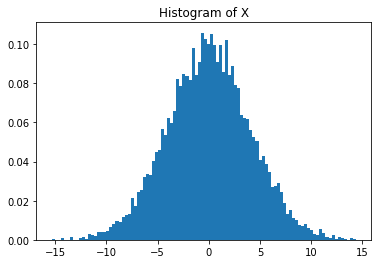

In [331]:
# 2
# We plot the distribution
plt.hist(X, bins=100, density=True)
plt.title("Histogram of X")
plt.show()

In [332]:
# 3
# Compute cumulative average of X
cum_avg = np.cumsum(X) / (np.arange(N) + 1)


# Cumulative average of X using pandas as this become handy when calculating the cumulative std
X_df = pd.DataFrame({"X": X})
cum_avg_df = X_df.expanding().mean()
cum_avg_df

,X
0,9.316428
1,3.765572
2,3.063126
3,0.988637
4,0.931156
...,...
9995,0.007297
9996,0.006989
9997,0.007977
9998,0.008421


In [333]:
# 4
# Cumulative standard error of the mean (sem) of X
cum_sem = X_df.expanding().sem()
cum_sem["X"][0] = 0

In [334]:
# 5
# We can use python to calculate the mean and median of X

print("Mean of X: ", np.mean(X))
print("Median of X: ", np.median(X))

# By the law of large numbers as the size N of the sample increases the mean of the sample approaches the mean of the population which should be 0



Mean of X:  0.007779447436003721
Median of X:  0.012064912940207227


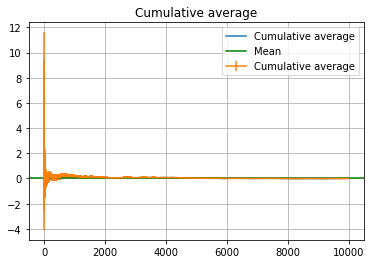

In [335]:
# 6
plt.plot(cum_avg_df, label="Cumulative average")
plt.title("Cumulative average")
plt.grid()


# errorbar with cum_sem as error bars
plt.errorbar(cum_avg_df.loc[0:10000, "X"].index, cum_avg_df.loc[0:10000, "X"], yerr=cum_sem.loc[0:10000, "X"], label="Cumulative average")

# horizontal line at mean
plt.axhline(y=np.mean(X), color="g", linestyle="-", label="Mean")

plt.legend()
plt.show()



In [336]:
# 7
# Cumulative median of X
cum_med_df = X_df.expanding().median()

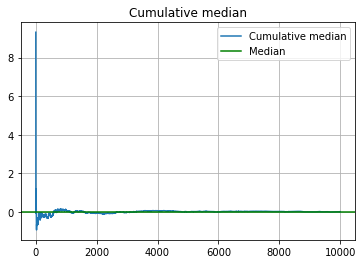

In [337]:
# 8
plt.plot(cum_med_df, label="Cumulative median")
plt.title("Cumulative median")
plt.grid()

# horizontal line at median
plt.axhline(y=np.median(X), color="g", linestyle="-", label="Median")
plt.legend()
plt.show()

In [338]:
# We create 1 function to calculate all the previous values in one go

def calculate_cumulative_stats(X):
    # Create dataframe from X
    X_df = pd.DataFrame({"X": X})


    # Histogram plot
    plt.figure(1)
    plt.hist(X, bins=100, density=True)
    plt.title("Histogram of X")
    
    plt.show()

    # Cumulative average of X
    cum_avg_df = X_df.expanding().mean()

    # Cumulative standard error of the mean (sem) of X
    cum_sem = X_df.expanding().sem()
    cum_sem["X"][0] = 0

    # Cumulative median of X
    cum_med_df = X_df.expanding().median()

    # Plots
    # Cumulative average of X
    plt.figure(2)
    plt.plot(cum_avg_df, label="Cumulative average")
    plt.title("Cumulative average")
    plt.grid()


    # errorbar with cum_sem as error bars
    plt.errorbar(cum_avg_df.loc[0:10000, "X"].index, cum_avg_df.loc[0:10000, "X"], yerr=cum_sem.loc[0:10000, "X"], label="Cumulative average")

    # horizontal line at mean
    plt.axhline(y=np.mean(X), color="g", linestyle="-", label="Mean")

    plt.legend()
    plt.show()
    

    plt.figure(3)
    # cumulative median of X
    plt.plot(cum_med_df, label="Cumulative median")
    plt.title("Cumulative median")
    plt.grid()

    # horizontal line at median
    plt.axhline(y=np.median(X), color="g", linestyle="-", label="Median")
    plt.legend()
    plt.show()

    return cum_avg_df, cum_sem, cum_med_df


## Pareto Distribution

In [339]:
xm = 1
alpha = 0.5
N = 10000


# sample from pareto distribution
P = np.random.pareto(alpha, N) + xm



In [340]:
np.mean(P)

# mean of both P and P_scipy
print("Mean of P: ", np.mean(P))


Mean of P:  15157.194075527459


In [341]:
# mean from formula
P_mean = alpha* xm /(alpha-1)

# median from formula
P_med = xm*2**(1/alpha)

print(f"{P_mean=} - {P_med=}")
print("From distribution:")
print(f"{np.mean(P)=} - {np.median(P)=}")



P_mean=-1.0 - P_med=4.0
From distribution:
np.mean(P)=15157.194075527459 - np.median(P)=4.0066291850389675


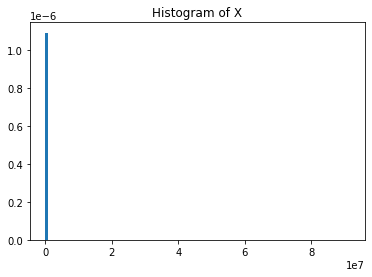

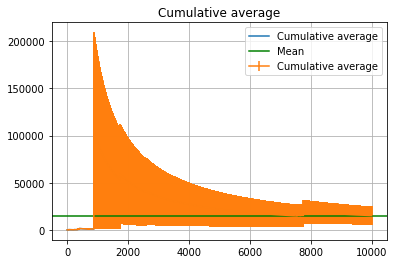

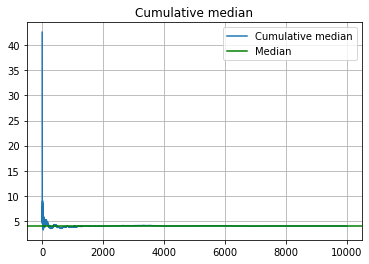

In [342]:
pareto_cum_avg_df, pareto_cum_sem, pareto_cum_med_df = calculate_cumulative_stats(P)

## Lognormal Distribution

In [343]:
mu, sigma = 0, 4

# lognormal

# sample from lognormal distribution
L = np.random.lognormal(mu, sigma, N)

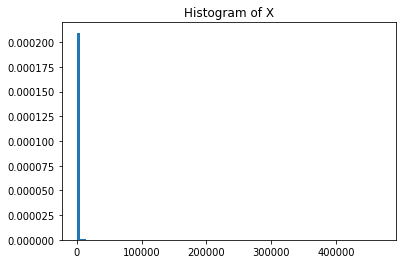

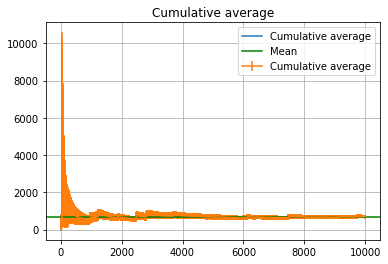

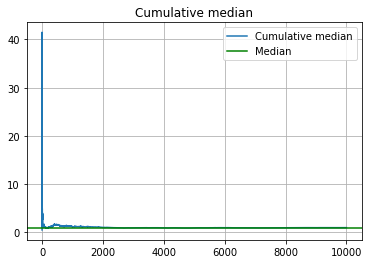

In [344]:
lognorm_cum_avg_df, lognorm_cum_sem, lognorm_cum_med_df = calculate_cumulative_stats(L)

## Citation distribution

In [345]:
# First we get the all the citation counts for all the papers from 2009
citation_counts = paper_df[paper_df["year"] == 2009]["citationCount"].values

shape of citation_counts: (1030,)
shape of citations_counts_sample: (10000,)


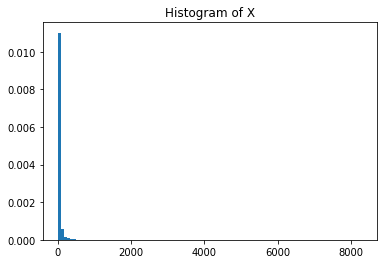

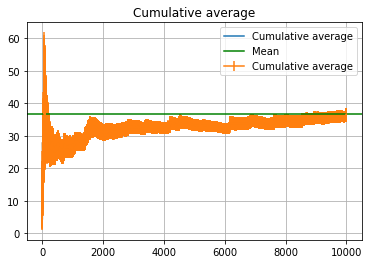

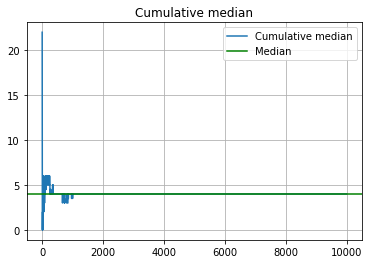

In [346]:
print(f"shape of citation_counts: {citation_counts.shape}")

# we only have 1000 papers from 2009 so we will instead sample from the whole dataframe


C = paper_df["citationCount"].sample(n=N).values

print(f"shape of citations_counts_sample: {C.shape}")



C_cum_avg_df, C_cum_sem, C_cum_med_df = calculate_cumulative_stats(C)



When we look at the many different plots we notice a common trend between the pareto, lognormal and citation distribution. This is they are highly influenced by outliers.

All 3 distribution plots show that they spike at one value, for the pareto distribution this is because the mean of the distribution for alpha less than 0 is $\inf$. If we inspect the actual mean of the 10000 samples we find that the mean if very different each time we run the code, where most samples are maybe in the range 0-100 while some are ridiciously high in the order of $10^8$ This makes sense as the pareto distribution is known as the 80-20% distribution, where 20% of the sample is responsible for 80% of the outcomes, so in this case, 20% of the 10000 samples are responsible for 80% of the total sum

91514400.64139244